In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housingcon/energy_final.csv


# Loading the Data

In [30]:
#Load the dataset
df = pd.read_csv("/kaggle/input/housingcon/energy_final.csv")
df

,dayofmonth,day,hour,temp,pressure,humidity,wind,visibility,dew_point,energy
0,11,1,17,6.31,733.75,92.00,6.17,53.42,5.05,330
1,11,1,18,5.92,734.20,91.75,5.25,40.00,4.68,250
2,11,1,19,6.00,734.91,89.25,6.00,40.00,4.31,360
3,11,1,20,6.00,735.28,87.58,6.00,40.00,4.02,750
4,11,1,21,5.83,735.57,87.42,6.00,40.00,3.82,620
...,...,...,...,...,...,...,...,...,...,...
3209,27,5,12,20.82,756.10,61.75,1.00,34.25,13.18,160
3210,27,5,14,21.92,755.80,59.00,2.00,21.58,13.48,610
3211,27,5,15,22.22,755.67,57.33,2.00,21.83,13.26,460
3212,27,5,16,22.88,755.38,55.00,2.40,22.60,13.28,590


### Split data into training and test sets

In [37]:
# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

#Define target and predictor variables
X = df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train the model

In [38]:
# Train the model with XGBoost 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 111.20414984043228


###  Evaluating the accuracy of the model

In [39]:
#Create function to plot accuracy of predicted against actual
def plot_accuracy(model):
    # Slice the test data for the first 24 hours
    test_df_2 = X_test.iloc[:24]

    # Make predictions on the test data
    y_predict = model.predict(test_df_2)

    # Create a new dataframe with the actual and predicted values for the first 24 hours
    predicted_values = pd.DataFrame({'Actual': y_test.iloc[:24].values, 'Predicted': y_predict})

    # Plot the actual and predicted values
    fig, ax = plt.subplots()
    predicted_values.plot(ax=ax)

    # Fill between the predicted and actual lines
    ax.fill_between(predicted_values.index, predicted_values['Actual'], predicted_values['Predicted'], alpha=0.2)
    
    # Show the plot
    plt.show()


In [40]:
#Function to see the importance  of each feature in the model
def plot_feature_importance(model):
    fi = pd.DataFrame(data= model.feature_importances_,
             index= model.feature_names_in_,
             columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()

<AxesSubplot:>

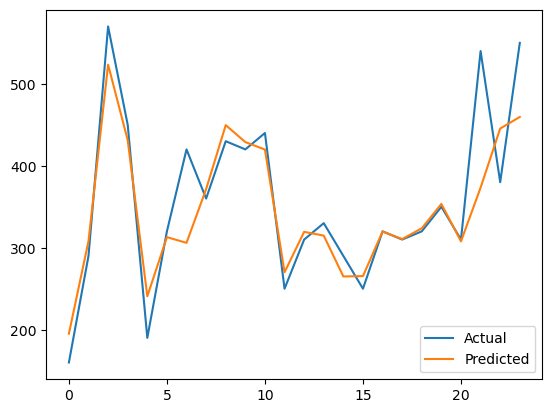

In [41]:
# Slice the test data for the first 24 hours
test_df_24 = test_df.iloc[:24]

# Create a new dataframe with the features for the first 24 hours
test_predict = test_df_24[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]

# Make predictions on the test_predict dataframe
y_predict = xgb_model.predict(test_predict)

# Create a new dataframe with the actual and predicted values for the first 24 hours
predicted_values = pd.DataFrame({'Actual': test_df_24['energy'].values, 'Predicted': y_predict})

# Set the index of the predicted_values dataframe to be the first 24 hours
# predicted_values.index = test_df_24.index

# Plot the actual and predicted values
predicted_values.plot()

### Accuracy of UnTuned Model

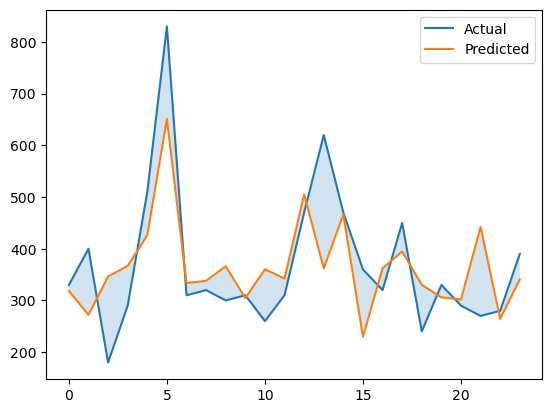

In [42]:
plot_accuracy(xgb_model)

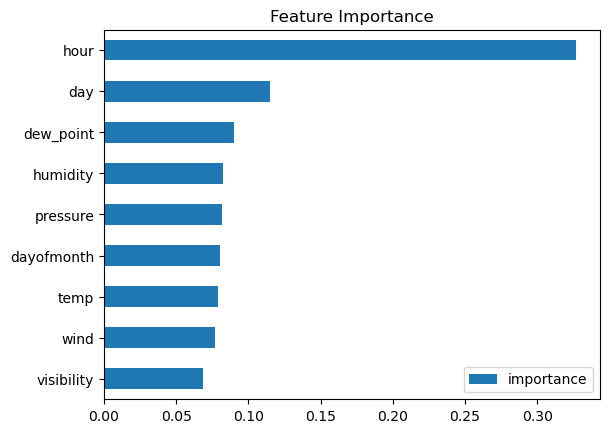

In [43]:
plot_feature_importance(xgb_model)

In [14]:
### Keep this bench mark cell

<AxesSubplot:>

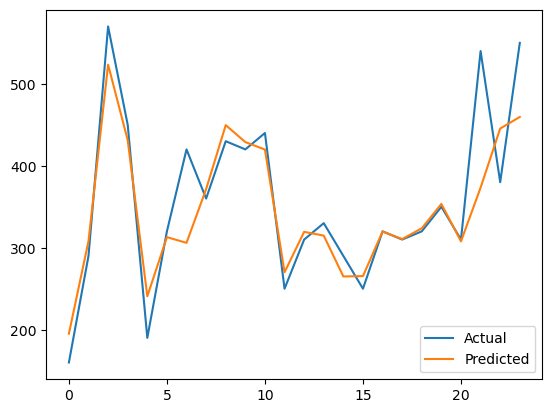

In [24]:
# Slice the test data for the first 24 hours
test_df_24 = test_df.iloc[:24]

# Create a new dataframe with the features for the first 24 hours
test_predict = test_df_24[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]

# Make predictions on the test_predict dataframe
y_predict = xgb_model.predict(test_predict)

# Create a new dataframe with the actual and predicted values for the first 24 hours
predicted_values = pd.DataFrame({'Actual': test_df_24['energy'].values, 'Predicted': y_predict})

# Set the index of the predicted_values dataframe to be the first 24 hours
# predicted_values.index = test_df_24.index

# Plot the actual and predicted values
predicted_values.plot()

# Hyperparameter Tuning

#### RandomizedSearch CrossValidation

In [44]:
#Use RandomisedSearch to find the best model parameters
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'n_estimators': [50, 100, 150, 200, 250],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

xgb_model_randomized = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model_randomized, param_distributions=param_grid,
                                   n_iter=50, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)
print('Best hyperparameters:', random_search.best_params_)
print('Best CV score:', random_search.best_score_)

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best CV score: 0.42696779446283717


In [45]:
#Use the best parameters you got
xgb_model_randomized = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **random_search.best_params_)
xgb_model_randomized.fit(X_train, y_train)

# Evalaute performance
y_pred = xgb_model_randomized.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE on test set:', rmse)

RMSE on test set: 104.75737577572308


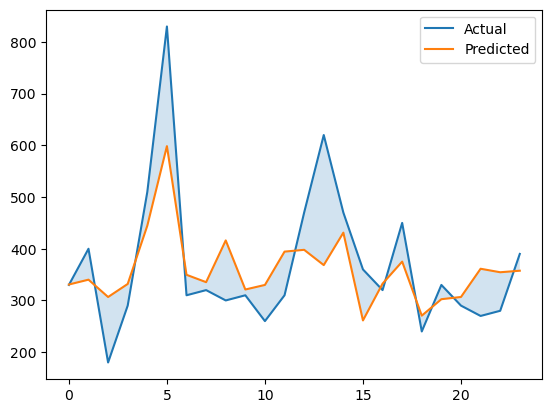

In [46]:
plot_accuracy(xgb_model_randomized)

In [11]:
#Save the model for use in web interface
import joblib
joblib.dump(xgb_model_randomized, 'xgb_model.pkl')

['xgb_model.pkl']

In [50]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)

0.45986043912120866


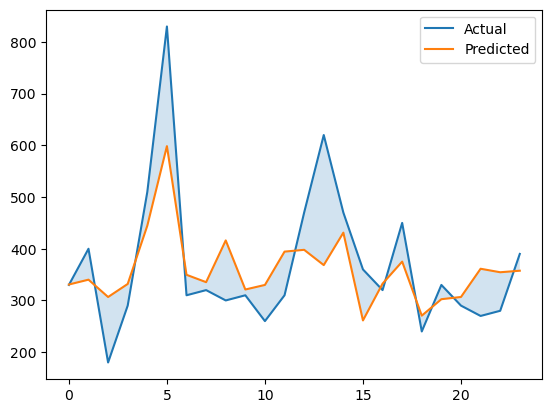

In [18]:
plot_accuracy(xgb_model_randomized)

In [20]:
#Use optuna to automate parameter tuning
import optuna
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Define the objective function that Optuna will optimize
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }
    
    # Create an XGBoost regressor with the hyperparameters suggested by Optuna
    xgb_model1 = xgb.XGBRegressor(**params)
    
    # Train the model on the training data
    xgb_model1.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred1 = xgb_model1.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred1)
    
    return mse

# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
if train_size > 0:
    train_df = df[:train_size]
    test_df = df[train_size:]
else:
    raise ValueError('Train size is too small. Please adjust the train-test split ratio.')
    
# Define input and output variables for the train and test sets
X_train = train_df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]
y_train = train_df['energy']
X_test = test_df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]
y_test = test_df['energy']

# Set up the Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization process
study.optimize(objective, n_trials=100)

# Print the best set of hyperparameters found by Optuna
print('Best trial:', study.best_trial.params)

# Train a final model using the best set of hyperparameters
best_params = study.best_trial.params
xgb_model1 = xgb.XGBRegressor(**best_params)
xgb_model1.fit(X_train, y_train)
y_pred = xgb_model1.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
# print('MAE:', mae)
print('RMSE:', rmse)

[I 2023-04-26 19:18:26,773] A new study created in memory with name: no-name-a571ee26-b281-4fae-90ef-7e5317dd5c0c
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.
[I 2023-04-26 19:18:27,372] Trial 0 finished with value: 135816.2699338811 and parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.0010598643331512648, 'subsample': 0.8499795612323243, 'colsample_bytree': 0.7354323903919315, 'gamma': 2.2159167961462947, 'reg_alpha': 5.046456587762059, 'reg_lambda': 8.543477110245908}. Best is trial 0 with value: 135816.2699338811.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.

Best trial: {'n_estimators': 277, 'max_depth': 8, 'learning_rate': 0.027148110774444217, 'subsample': 0.17906708071645636, 'colsample_bytree': 0.2578609239979004, 'gamma': 6.071218074510309, 'reg_alpha': 0.7086161650449528, 'reg_lambda': 5.8514722471337315}
RMSE: 118.02725701724438


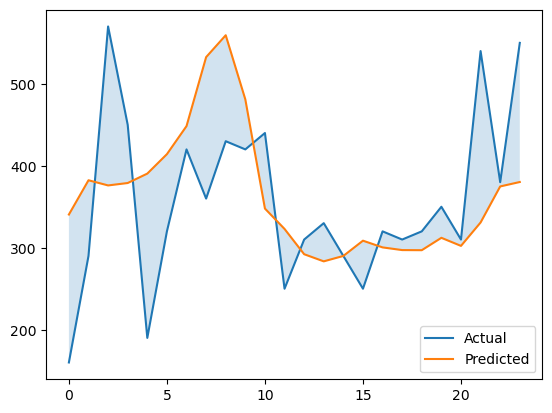

In [21]:
plot_accuracy(xgb_model1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Prepare the data
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# X_train = train_df[["day","hour","temp","humidity"]]
# y_train = train_df['energy']

# X_test = test_df[["day","hour","temp","humidity"]]
# y_test = test_df['energy']

# Reshape the input data to fit LSTM requirements
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('RMSE:', rmse)
print('R2 score:', r2)

Epoch 1/50
81/81 [==============================] - 2s 7ms/step - loss: 105212.4922 - val_loss: 71473.9609
Epoch 2/50
81/81 [==============================] - 0s 3ms/step - loss: 35746.5703 - val_loss: 25356.5449
Epoch 3/50
81/81 [==============================] - 0s 4ms/step - loss: 20540.9980 - val_loss: 19749.7168
Epoch 4/50
81/81 [==============================] - 0s 4ms/step - loss: 19960.7070 - val_loss: 19532.1484
Epoch 5/50
81/81 [==============================] - 0s 3ms/step - loss: 19919.8887 - val_loss: 19367.4805
Epoch 6/50
81/81 [==============================] - 0s 4ms/step - loss: 19864.0879 - val_loss: 19229.7910
Epoch 7/50
81/81 [==============================] - 0s 3ms/step - loss: 19806.9707 - val_loss: 19471.0645
Epoch 8/50
81/81 [==============================] - 0s 3ms/step - loss: 19750.3379 - val_loss: 19298.4062
Epoch 9/50
81/81 [==============================] - 0s 3ms/step - loss: 19705.3789 - val_loss: 19432.4219
Epoch 10/50
81/81 [==========================

#### BayesSearch


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import r2_score

# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Define input and output variables for the training and testing sets
X_train = train_df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind','visibility', 'dew_point']]
y_train = train_df['energy']

X_test = test_df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind','visibility', 'dew_point']]
y_test = test_df['energy']

# Define the hyperparameter space
param_space = {
    'max_depth': Integer(1, 10),
    'n_estimators': Integer(100, 1000),
    'learning_rate': Real(0.001, 1.0, 'log-uniform'),
    'gamma': Real(1e-9, 0.5, 'log-uniform'),
    'min_child_weight': Integer(1, 10),
    'max_delta_step': Integer(0, 20),
    'subsample': Real(0.01, 1.0, 'uniform'),
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),
    'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
    'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
    'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
}

# Define the XGBoost model
xgb_model_bayes = xgb.XGBRegressor(base_score=0.5, booster='gbtree', objective='reg:squarederror',
                             random_state=42, n_jobs=-1)

# Define the Bayesian search for hyperparameter optimization
bayes_cv = BayesSearchCV(
    estimator=xgb_model_bayes,
    search_spaces=param_space,
    scoring='neg_mean_absolute_error',
    n_iter=50,
    cv=5,
    verbose=0,
    n_jobs=-1,
    refit=True,
    random_state=42
)

# Fit the Bayesian search on the training data
result = bayes_cv.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best score: %f" % result.best_score_)
print("Best params: ", result.best_params_)

# Use the best model to predict on the test data
y_pred = result.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('R-squared:', r2)
# Evaluate the performance of the best model on the test data
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('MAE:', mae)
print('RMSE:', rmse)

Best score: -92.350911
Best params:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 3.5254144715876806e-05), ('learning_rate', 0.06340652457541918), ('max_delta_step', 19), ('max_depth', 3), ('min_child_weight', 1), ('n_estimators', 964), ('reg_alpha', 0.0032507697379744313), ('reg_lambda', 1000.0), ('scale_pos_weight', 1e-06), ('subsample', 0.2883980052687749)])
R-squared: 0.19009646328235386
MAE: 86.5382559911274
RMSE: 121.70300184019445


In [24]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

xgb_pipeline = Pipeline([("st_scaler", StandardScaler()), ("xgb_model", xgb.XGBRegressor())])
gbm_param_grid = {
    'xgb_model__subsample': np.arange(0.05, 1, 0.05),
    'xgb_model__max_depth': np.arange(3, 20, 1),
    'xgb_model__colsample_bytree': np.arange(.1, 1.05, 0.05)
}
randomized_neg_mse = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=gbm_param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=4
)
randomized_neg_mse.fit(X, y)

print("Best rmse: ", np.sqrt(np.abs(randomized_neg_mse.best_score_)))


Best rmse:  129.83192124837888


In [26]:
import lightgbm as lgb
X = df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the LGBM model
lgbm_model = lgb.LGBMRegressor(objective='regression', random_state=42)
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 107.46286931776692


### Using LGBM Regressor

In [ ]:
X = df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LGBMRegressor model
lgbm = LGBMRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [10, 20, 30],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Perform GridSearchCV
grid_search = GridSearchCV(lgbm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and CV score from GridSearchCV
print('Best hyperparameters from GridSearchCV:', grid_search.best_params_)
print('Best CV score from GridSearchCV:', grid_search.best_score_)

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'num_leaves': [10, 20, 30, 40, 50],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1, 5],
    'reg_lambda': [0, 0.1, 0.5, 1, 5]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(lgbm, param_distributions=param_distributions, n_iter=50, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)

# Print the best hyperparameters and CV score from RandomizedSearchCV
print('Best hyperparameters from RandomizedSearchCV:', random_search.best_params_)
print('Best CV score from RandomizedSearchCV:', random_search.best_score_)

# Use the best parameters from GridSearchCV
lgbm = LGBMRegressor(**grid_search.best_params_)
lgbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm.predict(X_test)

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMRegressor
# Define target and predictor variables
X = df[['dayofmonth', 'day', 'hour', 'temp', 'pressure', 'humidity', 'wind', 'visibility', 'dew_point']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LGBM model
lgbm_model = LGBMRegressor()

# Define parameter grid for GridSearch
param_grid = {'num_leaves': [30, 50, 100],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [-1, 5, 10],
              'n_estimators': [100, 200, 300],
              'reg_lambda': [0, 1, 10]}

# Perform GridSearch
grid_search = GridSearchCV(lgbm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print('Best hyperparameters:', grid_search.best_params_)
print('Best CV score:', grid_search.best_score_)

# Use the best hyperparameters
best_model = grid_search.best_estimator_

# Define parameter grid for RandomSearch
param_distributions = {'num_leaves': [10, 20, 30, 50, 100],
                       'learning_rate': [0.01, 0.05, 0.1, 0.2],
                       'max_depth': [-1, 5, 10, 20, 50],
                       'n_estimators': [50, 100, 200, 300],
                       'reg_lambda': [0, 0.1, 1, 10],
                       'subsample': [0.5, 0.7, 0.9],
                       'colsample_bytree': [0.5, 0.7, 0.9]}

# Perform RandomSearch
random_search = RandomizedSearchCV(lgbm_model, param_distributions=param_distributions, n_iter=50,
                                   cv=5, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print('Best hyperparameters:', random_search.best_params_)
print('Best CV score:', random_search.best_score_)

# Use the best hyperparameters
best_model = random_search.best_estimator_

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 30, 'reg_lambda': 1}
Best CV score: 0.42403210238818784
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 1, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV score: 0.4280083201552628
RMSE: 105.50178631737747


<AxesSubplot:>

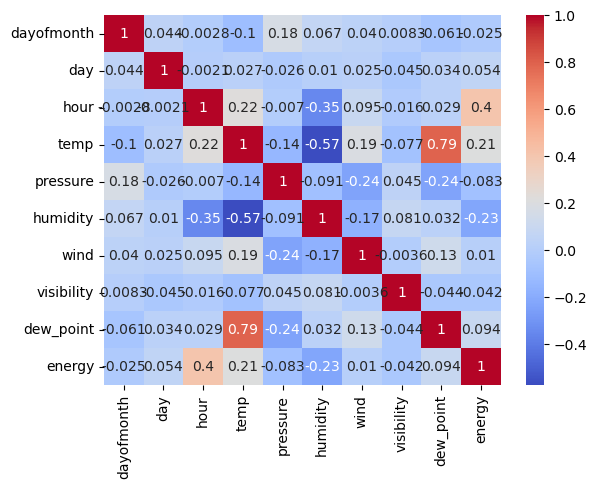

In [14]:
#Carry on furthur selection.Plotting correlation matrix to see which features are affecting enenergy usage more .
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix,cmap="coolwarm",annot=True)


Explained variance ratio: [0.5941901  0.26962399]


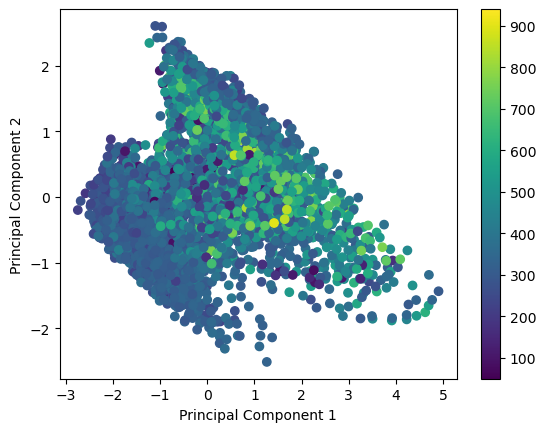

In [56]:
#Choose the ones with high absolute correlation coeffecients and see the  variance ratio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define target and predictor variables
X = df[[ 'temp', 'humidity','hour']]
y = df['energy']

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Print the explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Visualize the results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [22]:
#Use these features again
#Define target and predictor variables
X = df[[ 'hour', 'temp', 'humidity']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'n_estimators': [50, 100, 150, 200, 250],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

xgb_model_randomized = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model_randomized, param_distributions=param_grid,
                                   n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print('Best hyperparameters:', random_search.best_params_)
print('Best CV score:', random_search.best_score_)





Best hyperparameters: {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best CV score: 0.3252263859683701


In [23]:
#Use the best parameters you got
xgb_model_randomized = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **random_search.best_params_)
xgb_model_randomized.fit(X_train, y_train)

# Evalaute performance
y_pred = xgb_model_randomized.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE on test set:', rmse)

RMSE on test set: 117.38199710565712


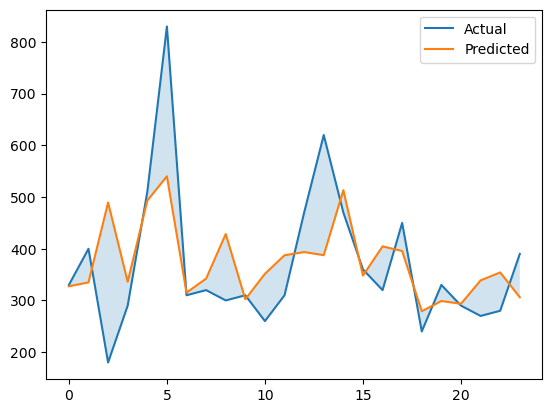

In [28]:
plot_accuracy(xgb_model_randomized )

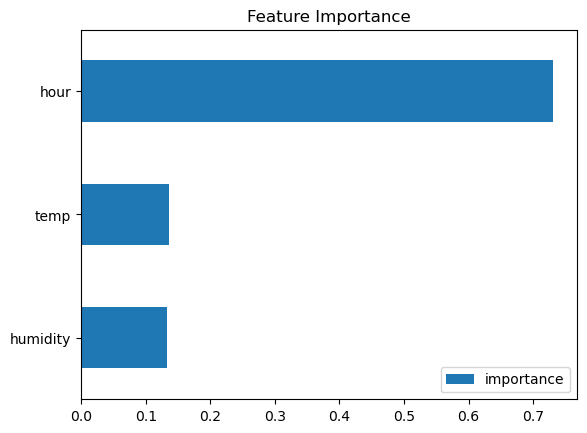

In [29]:
plot_feature_importance(xgb_model_randomized)

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Define target and predictor variables
X = df[['dayofmonth', 'day', 'hour', 'temp', 'humidity']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Best Model RMSE:', rmse)
print('Best Parameters:', best_params)


Best Model RMSE: 105.98689086098105
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.9}


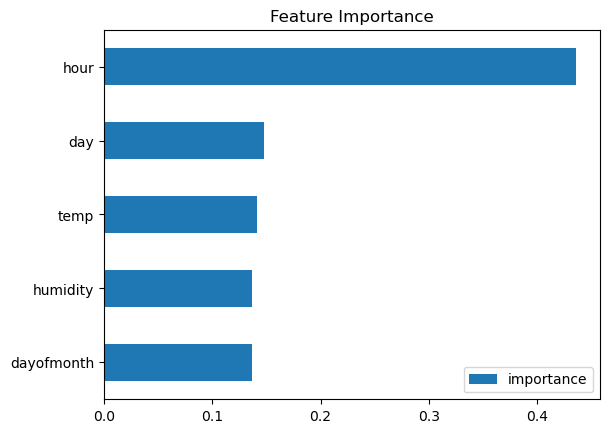

In [62]:
plot_feature_importance(best_model)

In [61]:
r2 = r2_score(y_test, y_pred)
r2

0.44710702694721205

Explained variance ratio: [0.52474374 0.33365695]


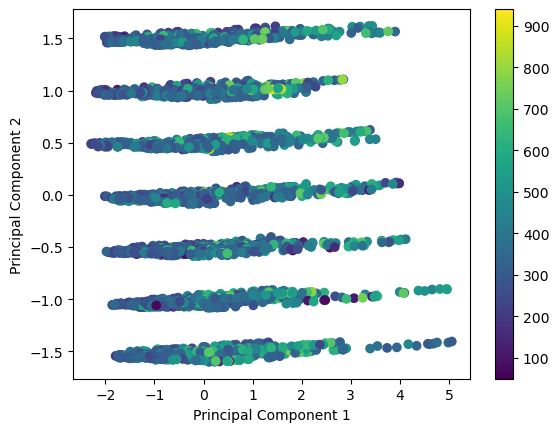

In [77]:
# Change features again
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define target and predictor variables
X = df[[ 'day', 'temp', 'humidity']]
y = df['energy']

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Print the explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Visualize the results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


In [63]:
#Use optuna to automate parameter tuning
import optuna
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Define the objective function that Optuna will optimize
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }
    
    # Create an XGBoost regressor with the hyperparameters suggested by Optuna
    xgb_model1 = xgb.XGBRegressor(**params)
    
    # Train the model on the training data
    xgb_model1.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred1 = xgb_model1.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred1)
    
    return mse

# Define target and predictor variables
X = df[['dayofmonth', 'day', 'hour', 'temp', 'humidity']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization process
study.optimize(objective, n_trials=100)

# Print the best set of hyperparameters found by Optuna
print('Best trial:', study.best_trial.params)

# Train a final model using the best set of hyperparameters
best_params = study.best_trial.params
xgb_model1 = xgb.XGBRegressor(**best_params)
xgb_model1.fit(X_train, y_train)
y_pred = xgb_model1.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
# print('MAE:', mae)
print('RMSE:', rmse)

[I 2023-04-27 18:29:30,746] A new study created in memory with name: no-name-79fc428a-2156-47e5-a453-44da1d181fdf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # This is added back by InteractiveShellApp.init_path()
[I 2023-04-27 18:29:31,286] Trial 0 finished with value: 34847.40047409068 and parameters: {'n_estimators': 196, 'max_depth': 6, 'learning_rate': 0.005268160923130461, 'subsample': 0.23619802938154677, 'colsample_bytree': 0.9951919885450277, 'gamma': 7.352111877362109, 'reg_alpha': 7.157798683821236, 'reg_lambda': 7.430803902406699}. Best is trial 0 with value: 34847.40047409068.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in 

Best trial: {'n_estimators': 340, 'max_depth': 8, 'learning_rate': 0.03347879394836059, 'subsample': 0.20297016736530166, 'colsample_bytree': 0.8576909068089034, 'gamma': 4.005464658446236, 'reg_alpha': 6.989655428095747, 'reg_lambda': 3.3713476606023973}
RMSE: 103.5781530728294


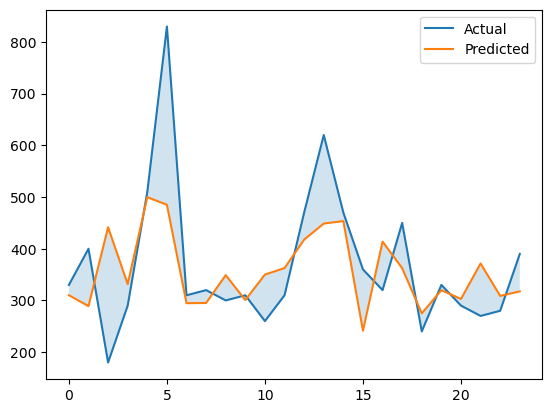

In [64]:
plot_accuracy(xgb_model1)

In [65]:
r2 = r2_score(y_test, y_pred)
r2

0.4719523778264668

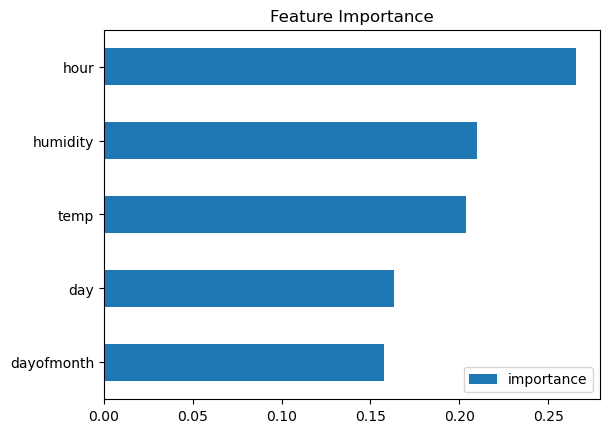

In [66]:
plot_feature_importance(xgb_model1)

### Using RandomForestRegressor with GridsearchCV

In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data
X = df[['hour', 'temp', 'humidity', 'day']]
y = df['energy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
print('Best Parameters:', best_params)

RMSE: 109.3058362726228
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


# Conclusion
### The best model is xgb_model1 that was tuned using optuna and achieved an rmse of 103 and an r2 of 0.48  approx 0.5.It takes these parameters to predict ['dayofmonth', 'day', 'hour', 'temp', 'humidity'].These explain 80% variability to energy usage according to our PCA

In [82]:
#Save the model
import joblib
joblib.dump(xgb_model1, 'best_xgb_model.pkl')

['best_xgb_model.pkl']